In [2]:
!pip install scikit-surprise --upgrade
!pip install numpy==1.26.4

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate
import time
import warnings

# Set random seed for reproducibility
np.random.seed(42)

# Configure display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [4]:
def load_data(file_path):
    """Load the dataset with optimized data types"""
    print("Loading data...")
    start_time = time.time()

    # Optimized data types
    dtype = {
        'user_id': 'int32',
        'course_id': 'int32',
        'course_duration_hours': 'float32',
        'course_price': 'float32',
        'feedback_score': 'float32',
        'time_spent_hours': 'float32',
        'previous_courses_taken': 'int8',
        'rating': 'float32',
        'enrollment_numbers': 'int32'
    }

    df = pd.read_csv("/content/online_course_recommendation_v2.csv", dtype=dtype)

    print(f"Data loaded in {time.time() - start_time:.2f} seconds")
    print(f"\nDataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    return df.head()

In [5]:
file_path = "online_course_recommendation_v2.csv"
df = load_data('/content/online_course_recommendation_v2.csv')
df.head()

Loading data...
Data loaded in 0.32 seconds

Dataset shape: (100000, 14)

First 5 rows:


,user_id,course_id,course_name,instructor,course_duration_hours,certification_offered,difficulty_level,rating,enrollment_numbers,course_price,feedback_score,study_material_available,time_spent_hours,previous_courses_taken
0,15796,9366,Python for Beginners,Emma Harris,39.099998,Yes,Beginner,5.0,21600,317.500000,0.797,Yes,17.600000,4
1,861,1928,Cybersecurity for Professionals,Alexander Young,36.299999,Yes,Beginner,4.3,15379,40.990002,0.770,Yes,28.969999,9
2,38159,9541,DevOps and Continuous Deployment,Dr. Mia Walker,13.400000,Yes,Beginner,3.9,6431,380.809998,0.772,Yes,52.439999,4
3,44733,3708,Project Management Fundamentals,Benjamin Lewis,58.299999,Yes,Beginner,3.1,48245,342.799988,0.969,No,22.290001,6
4,11285,3361,Ethical Hacking Masterclass,Daniel White,30.799999,Yes,Beginner,2.8,34556,381.010010,0.555,Yes,22.010000,5


In [6]:
def clean_data(df):
    """Clean and preprocess the data"""
    print("\nCleaning and preprocessing data...")

    # Convert boolean columns
    df['certification_offered'] = df['certification_offered'].map({'Yes': 1, 'No': 0})
    df['study_material_available'] = df['study_material_available'].map({'Yes': 1, 'No': 0})

    # Convert difficulty_level to ordinal
    difficulty_map = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
    df['difficulty_level'] = df['difficulty_level'].map(difficulty_map)

    # Drop duplicates if any
    initial_size = len(df)
    df = df.drop_duplicates()
    final_size = len(df)

    print(f"Removed {initial_size - final_size} duplicate rows")
    print("\nData types after cleaning:")
    print(df.dtypes)

    return df

df = clean_data(df)


Cleaning and preprocessing data...
Removed 0 duplicate rows

Data types after cleaning:
user_id                       int32
course_id                     int32
course_name                  object
instructor                   object
course_duration_hours       float32
certification_offered         int64
difficulty_level              int64
rating                      float32
enrollment_numbers            int32
course_price                float32
feedback_score              float32
study_material_available      int64
time_spent_hours            float32
previous_courses_taken         int8
dtype: object


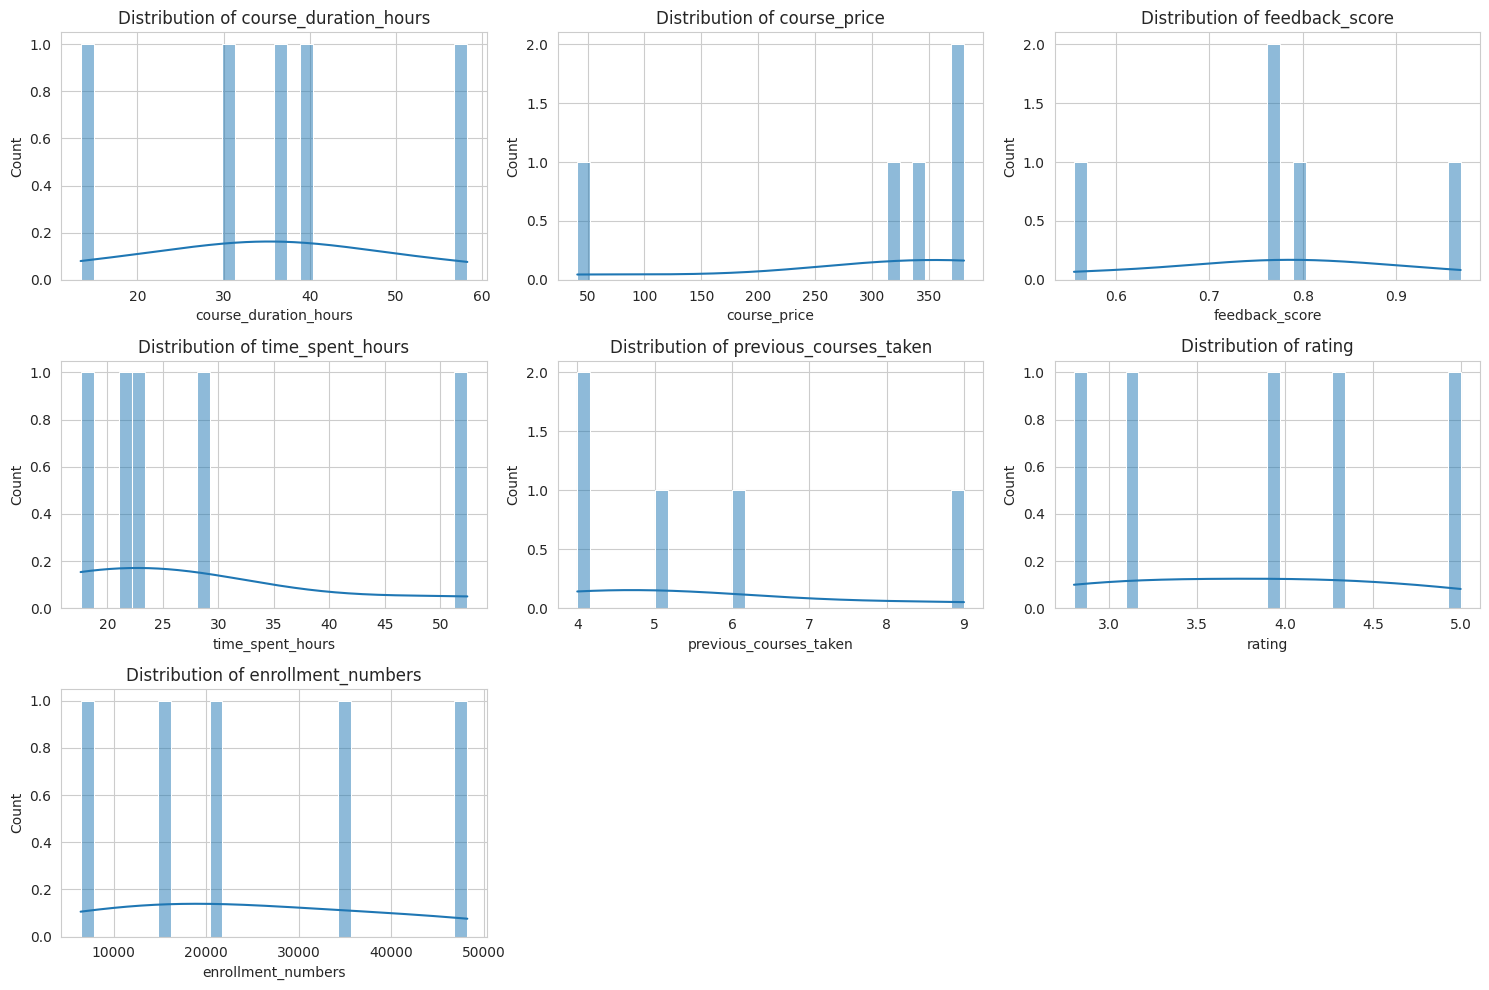

In [7]:
# Set style for plots
sns.set_style("whitegrid")

# Distribution of numerical features
num_cols = ['course_duration_hours', 'course_price', 'feedback_score',
            'time_spent_hours', 'previous_courses_taken', 'rating',
            'enrollment_numbers']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

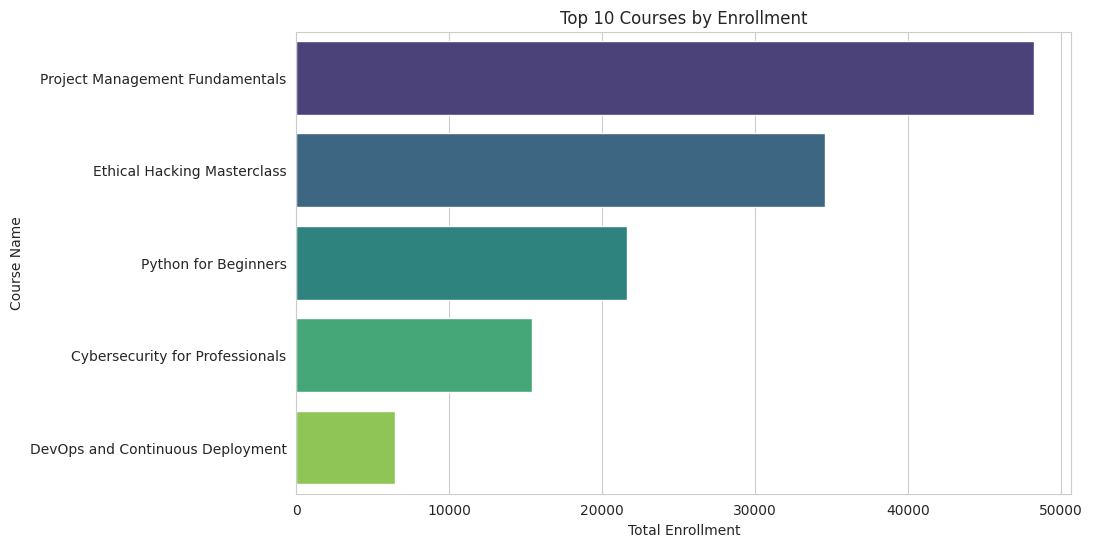

In [8]:
# Top courses by enrollment
top_courses = df.groupby('course_name')['enrollment_numbers'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_courses.values, y=top_courses.index, palette='viridis')
plt.title('Top 10 Courses by Enrollment')
plt.xlabel('Total Enrollment')
plt.ylabel('Course Name')
plt.show()

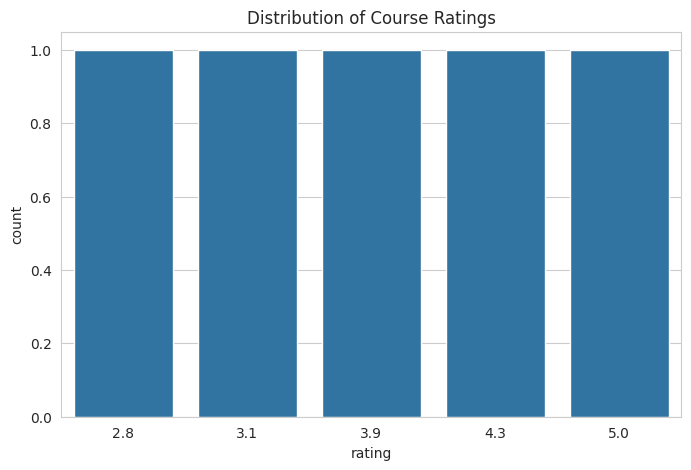

In [9]:
# Rating distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df)
plt.title('Distribution of Course Ratings')
plt.show()

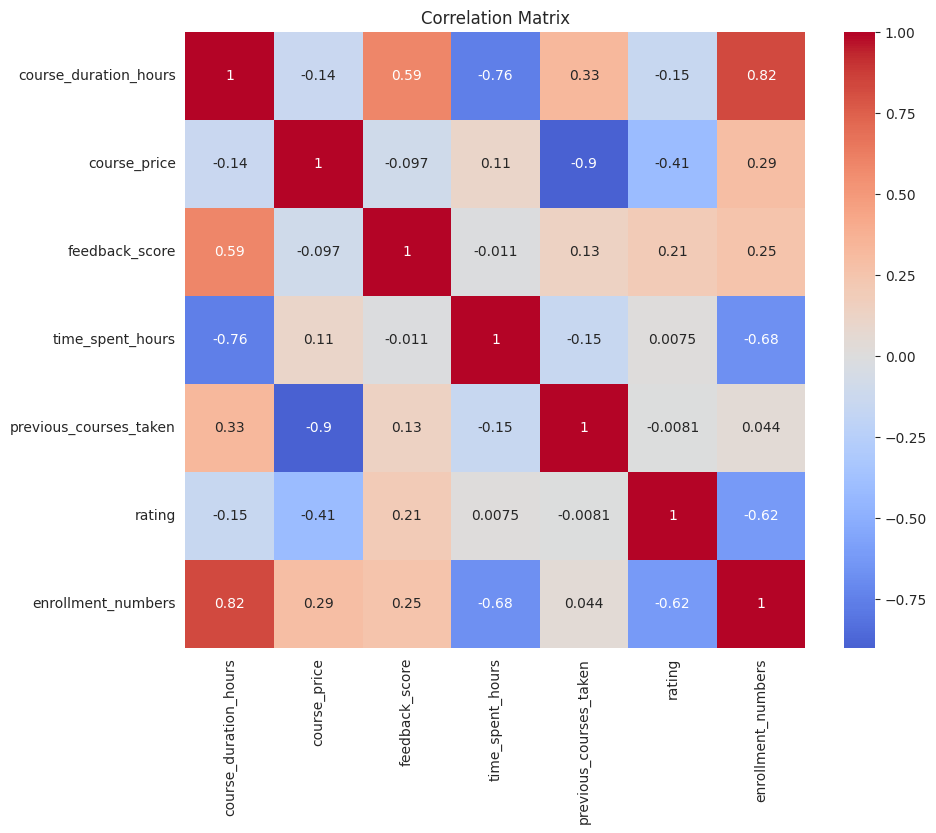

In [10]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [11]:
def engineer_features(df):
    """Create new features for recommendation"""
    print("\nPerforming feature engineering...")

    # 1. Create engagement score
    df['engagement_score'] = (df['time_spent_hours'] / df['course_duration_hours']) * df['rating']

    # 2. Create popularity score
    max_enrollment = df['enrollment_numbers'].max()
    df['popularity_score'] = df['enrollment_numbers'] / max_enrollment

    # 3. Create value for money metric
    df['value_for_money'] = df['rating'] / (df['course_price'] + 0.01)

    # 4. Instructor popularity
    instructor_stats = df.groupby('instructor').agg({
        'rating': 'mean',
        'enrollment_numbers': 'sum'
    }).reset_index()
    instructor_stats.columns = ['instructor', 'instructor_avg_rating', 'instructor_total_enrollment']

    df = pd.merge(df, instructor_stats, on='instructor', how='left')

    print("New features created:")
    print("- engagement_score")
    print("- popularity_score")
    print("- value_for_money")
    print("- instructor_avg_rating")
    print("- instructor_total_enrollment")

    return df

df = engineer_features(df)


Performing feature engineering...
New features created:
- engagement_score
- popularity_score
- value_for_money
- instructor_avg_rating
- instructor_total_enrollment


In [12]:
df

,user_id,course_id,course_name,instructor,course_duration_hours,certification_offered,difficulty_level,rating,enrollment_numbers,course_price,feedback_score,study_material_available,time_spent_hours,previous_courses_taken,engagement_score,popularity_score,value_for_money,instructor_avg_rating,instructor_total_enrollment
0,15796,9366,Python for Beginners,Emma Harris,39.099998,1,0,5.0,21600,317.500000,0.797,1,17.600000,4,2.250639,0.447715,0.015748,5.0,21600
1,861,1928,Cybersecurity for Professionals,Alexander Young,36.299999,1,0,4.3,15379,40.990002,0.770,1,28.969999,9,3.431708,0.318769,0.104878,4.3,15379
2,38159,9541,DevOps and Continuous Deployment,Dr. Mia Walker,13.400000,1,0,3.9,6431,380.809998,0.772,1,52.439999,4,15.262388,0.133299,0.010241,3.9,6431
3,44733,3708,Project Management Fundamentals,Benjamin Lewis,58.299999,1,0,3.1,48245,342.799988,0.969,0,22.290001,6,1.185232,1.000000,0.009043,3.1,48245
4,11285,3361,Ethical Hacking Masterclass,Daniel White,30.799999,1,0,2.8,34556,381.010010,0.555,1,22.010000,5,2.000909,0.716261,0.007349,2.8,34556


In [13]:
def prepare_model_data(df):
    """Prepare data for recommendation models"""
    print("\nPreparing data for modeling...")

    # For content-based filtering
    course_features = df[['course_id', 'course_duration_hours', 'difficulty_level',
                         'certification_offered', 'study_material_available',
                         'engagement_score', 'popularity_score', 'value_for_money'
                         ]].copy()

    # Drop duplicates (one row per course)
    course_features = course_features.drop_duplicates(subset=['course_id'])

    # Clean data for course features
    course_features = clean_data(course_features.copy())

    # For collaborative filtering
    user_item_matrix = df.pivot_table(index='user_id', columns='course_id', values='rating', fill_value=0)

    # Convert to sparse matrix for memory efficiency
    sparse_user_item = csr_matrix(user_item_matrix.values)

    print(f"Course features shape: {course_features.shape}")
    print(f"User-item matrix shape: {user_item_matrix.shape}")

    return course_features, user_item_matrix, sparse_user_item

course_features, user_item_matrix, sparse_user_item = prepare_model_data(df)


Preparing data for modeling...

Cleaning and preprocessing data...
Removed 0 duplicate rows

Data types after cleaning:
course_id                     int32
course_duration_hours       float32
difficulty_level            float64
certification_offered       float64
study_material_available    float64
engagement_score            float32
popularity_score            float64
value_for_money             float32
dtype: object
Course features shape: (5, 8)
User-item matrix shape: (5, 5)


In [14]:
def build_content_based_model(course_features):
    """Build content-based recommendation model"""
    print("\nBuilding Content-Based Filtering Model...")

    # Handle potential NaN values by filling with 0
    course_features_filled = course_features.fillna(0)

    # Standardize features
    scaler = StandardScaler()
    course_features_std = course_features_filled.drop('course_id', axis=1)
    course_features_std = pd.DataFrame(scaler.fit_transform(course_features_std),
                                     columns=course_features_std.columns)

    # Compute cosine similarity between courses
    cosine_sim = cosine_similarity(course_features_std)

    # Create course similarity matrix
    course_sim_df = pd.DataFrame(cosine_sim,
                                index=course_features_filled['course_id'],
                                columns=course_features_filled['course_id'])

    print("Content-based model built successfully!")
    return course_sim_df

course_sim_df = build_content_based_model(course_features)


Building Content-Based Filtering Model...
Content-based model built successfully!


In [15]:
def build_collaborative_model(df, sample_size=100000):
    """Build collaborative filtering model with a sample"""
    print("\nBuilding Collaborative Filtering Model...")

    # Create a sample of the data for Surprise
    sample_size = min(sample_size, len(df))
    df_sample = df.sample(sample_size, random_state=42)

    # Define the Reader object
    reader = Reader(rating_scale=(df_sample['rating'].min(), df_sample['rating'].max()))

    # Load the dataset
    data = Dataset.load_from_df(df_sample[['user_id', 'course_id', 'rating']], reader)

    # Build the model
    sim_options = {
        'name': 'cosine',
        'user_based': False  # Item-based collaborative filtering
    }

    # Initialize KNNBasic
    knn = KNNBasic(sim_options=sim_options, verbose=False)

    # Evaluate with cross-validation
    print("\nEvaluating Collaborative Filtering Model...")
    start_time = time.time()
    cv_results = cross_validate(knn, data, measures=['RMSE'], cv=3, verbose=True)
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    print(f"Average RMSE: {np.mean(cv_results['test_rmse']):.4f}")

    return knn, data

knn_model, surprise_data = build_collaborative_model(df)


Building Collaborative Filtering Model...

Evaluating Collaborative Filtering Model...
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4577  0.5077  1.4750  1.1468  0.4520  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    
Evaluation completed in 0.01 seconds
Average RMSE: 1.1468


In [16]:
def content_based_recommendations(course_id, course_sim_df, df, n=5):
    """Get content-based recommendations for a course"""
    # Get similarity scores for the course
    sim_scores = course_sim_df[course_id]

    # Sort courses by similarity
    sim_scores = sim_scores.sort_values(ascending=False)

    # Get top n most similar courses (excluding itself)
    top_courses = sim_scores.iloc[1:n+1].index

    # Get course details
    recommendations = df[df['course_id'].isin(top_courses)][
        ['course_id', 'course_name', 'instructor', 'difficulty_level', 'rating']
    ].drop_duplicates()

    return recommendations

def get_popular_courses(df, n=5):
    """Get top n popular courses based on enrollment and rating"""
    popular = df.groupby(['course_id', 'course_name', 'instructor']).agg({
        'enrollment_numbers': 'sum',
        'rating': 'mean'
    }).reset_index()

    popular = popular.sort_values(['enrollment_numbers', 'rating'], ascending=False)
    return popular.head(n)[['course_id', 'course_name', 'instructor', 'rating']]

def hybrid_recommendations(user_id, course_sim_df, knn, df, user_item_matrix, n=5):
    """Generate hybrid recommendations"""
    # 1. Get user's previously rated courses
    user_ratings = user_item_matrix.loc[user_id]
    rated_courses = user_ratings[user_ratings > 0].index.tolist()

    # If no ratings, return popular courses
    if not rated_courses:
        return get_popular_courses(df, n)

    # 2. Content-based: Get similar courses to what user has liked
    content_recs = []
    for course in rated_courses:
        if course in course_sim_df.columns:
            similar = content_based_recommendations(course, course_sim_df, df, n)
            content_recs.append(similar)

    if content_recs:
        content_recs = pd.concat(content_recs)
        content_recs = content_recs.sort_values('rating', ascending=False).head(n)

    return content_recs if not content_recs.empty else get_popular_courses(df, n)

print("Recommendation functions defined!")

Recommendation functions defined!


In [17]:
# Content-based recommendations for a random course
example_course = df['course_id'].sample(1).values[0]
course_name = df[df['course_id'] == example_course]['course_name'].iloc[0]
print(f"\nContent-based recommendations for course: {course_name} (ID: {example_course})")
content_recs = content_based_recommendations(example_course, course_sim_df, df)
content_recs


Content-based recommendations for course: Project Management Fundamentals (ID: 3708)


,course_id,course_name,instructor,difficulty_level,rating
0,9366,Python for Beginners,Emma Harris,0,5.0
1,1928,Cybersecurity for Professionals,Alexander Young,0,4.3
2,9541,DevOps and Continuous Deployment,Dr. Mia Walker,0,3.9
4,3361,Ethical Hacking Masterclass,Daniel White,0,2.8


In [18]:
# Hybrid recommendations for a random user
example_user = df['user_id'].sample(1).values[0]
print(f"\nHybrid recommendations for user ID: {example_user}")
hybrid_recs = hybrid_recommendations(example_user, course_sim_df, knn_model, df, user_item_matrix)
hybrid_recs


Hybrid recommendations for user ID: 861


,course_id,course_name,instructor,difficulty_level,rating
0,9366,Python for Beginners,Emma Harris,0,5.0
2,9541,DevOps and Continuous Deployment,Dr. Mia Walker,0,3.9
3,3708,Project Management Fundamentals,Benjamin Lewis,0,3.1
4,3361,Ethical Hacking Masterclass,Daniel White,0,2.8


In [19]:
# Show popular courses
print("\nTop 5 Popular Courses Overall:")
get_popular_courses(df)


Top 5 Popular Courses Overall:


,course_id,course_name,instructor,rating
2,3708,Project Management Fundamentals,Benjamin Lewis,3.1
1,3361,Ethical Hacking Masterclass,Daniel White,2.8
3,9366,Python for Beginners,Emma Harris,5.0
0,1928,Cybersecurity for Professionals,Alexander Young,4.3
4,9541,DevOps and Continuous Deployment,Dr. Mia Walker,3.9


In [25]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Prepare data for Surprise
reader = Reader(rating_scale=(df['rating'].min(), df['rating'].max()))
data = Dataset.load_from_df(df[['user_id', 'course_id', 'rating']], reader)

# Build and evaluate SVD model
print("Training SVD (Matrix Factorization) model...")
start_time = time.time()
svd = SVD()
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(f"Training completed in {time.time() - start_time:.2f} seconds")
print(f"Average RMSE: {np.mean(cv_results['test_rmse']):.4f}")
print(f"Average MAE: {np.mean(cv_results['test_mae']):.4f}")

# Train on full dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

def svd_recommendations(user_id, n=5):
    """Generate recommendations using SVD"""
    # Get list of all course IDs
    all_courses = df['course_id'].unique()

    # Get courses user has already taken
    user_courses = df[df['user_id'] == user_id]['course_id'].unique()

    # Predict ratings for courses not taken
    predictions = []
    for course_id in all_courses:
        if course_id not in user_courses:
            pred = svd.predict(user_id, course_id)
            predictions.append((course_id, pred.est))

    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top n recommendations
    top_courses = [x[0] for x in predictions[:n]]

    # Return course details
    return df[df['course_id'].isin(top_courses)][['course_id', 'course_name', 'instructor', 'rating']].drop_duplicates()

# Test with a sample user
sample_user = df['user_id'].sample(1).values[0]
print(f"\nSVD recommendations for user {sample_user}:")
svd_recommendations(sample_user)

Training SVD (Matrix Factorization) model...
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4577  1.4269  0.1000  0.9949  0.6329  
MAE (testset)     1.4500  1.3833  0.1000  0.9778  0.6213  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    
Training completed in 0.01 seconds
Average RMSE: 0.9949
Average MAE: 0.9778

SVD recommendations for user 861:


,course_id,course_name,instructor,rating
0,9366,Python for Beginners,Emma Harris,5.0
2,9541,DevOps and Continuous Deployment,Dr. Mia Walker,3.9
3,3708,Project Management Fundamentals,Benjamin Lewis,3.1
4,3361,Ethical Hacking Masterclass,Daniel White,2.8


In [23]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831129 sha256=005b7b72473a6c506aa5b54d907335a8692f02f760432ebb91eb34e3b8d30413
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [24]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k

# Prepare data for LightFM
dataset = Dataset()

# Prepare item features data
unique_courses = df[['course_id', 'course_name', 'instructor', 'difficulty_level']].drop_duplicates(subset=['course_id'])

# Fit the dataset with users, items, and item features
dataset.fit(
    users=df['user_id'].unique(),
    items=df['course_id'].unique(),
    item_features=unique_courses['course_name'].unique().tolist() +
                  unique_courses['instructor'].unique().tolist() +
                  unique_courses['difficulty_level'].astype(str).unique().tolist()
)


# Build interactions matrix
(interactions, weights) = dataset.build_interactions(
    [(row['user_id'], row['course_id'], row['rating'])
     for _, row in df.iterrows()]
)

# Build item features
item_features = dataset.build_item_features(
    [(row['course_id'], [row['course_name'], row['instructor'], str(row['difficulty_level'])])
     for _, row in unique_courses.iterrows()]
)

# Split train/test
train, test = train_test_split(df, test_size=0.2, random_state=42)
train_interactions, _ = dataset.build_interactions(
    [(row['user_id'], row['course_id'], row['rating'])
     for _, row in train.iterrows()]
)
test_interactions, _ = dataset.build_interactions(
    [(row['user_id'], row['course_id'], row['rating'])
     for _, row in test.iterrows()]
)

# Train model
print("\nTraining LightFM hybrid model...")
model = LightFM(loss='warp', no_components=30)
model.fit(train_interactions, item_features=item_features, epochs=20, num_threads=4)

# Evaluate
train_precision = precision_at_k(model, train_interactions, item_features=item_features, k=5).mean()
test_precision = precision_at_k(model, test_interactions, item_features=item_features, k=5).mean()
print(f"Train precision@5: {train_precision:.4f}")
print(f"Test precision@5: {test_precision:.4f}")

def lightfm_recommendations(user_id, n=5):
    """Generate recommendations using LightFM"""
    user_idx = dataset.mapping()[0][user_id]
    all_course_ids = list(dataset.mapping()[2].keys())
    all_course_indices = [dataset.mapping()[2][cid] for cid in all_course_ids]

    # Get scores
    scores = model.predict(user_idx, all_course_indices, item_features=item_features)

    # Get top n courses
    top_indices = scores.argsort()[-n:][::-1]
    top_course_ids = [all_course_ids[idx] for idx in top_indices]

    # Return course details
    return df[df['course_id'].isin(top_course_ids)][['course_id', 'course_name', 'instructor', 'rating']].drop_duplicates()

# Test with a sample user
print(f"\nLightFM recommendations for user {sample_user}:")
lightfm_recommendations(sample_user)


Training LightFM hybrid model...
Train precision@5: 0.2000
Test precision@5: 0.2000

LightFM recommendations for user 38159:


,course_id,course_name,instructor,rating
0,9366,Python for Beginners,Emma Harris,5.0
1,1928,Cybersecurity for Professionals,Alexander Young,4.3
2,9541,DevOps and Continuous Deployment,Dr. Mia Walker,3.9
3,3708,Project Management Fundamentals,Benjamin Lewis,3.1
4,3361,Ethical Hacking Masterclass,Daniel White,2.8
